In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.0, rc={"lines:linewidth": 2.5})

In [3]:
import gurobipy as gp
from gurobipy import GRB

In [4]:
import os
import re

In [5]:
import warnings
warnings.filterwarnings('ignore')

tickerList = ['AMZN', 'GOOGL', 'JNJ', 'JPM', 'MSFT', 'PG', 'TSLA', 'V', 'WMT']

In [6]:
data_path = f'data/options_call_askbid/'  # updated data: when selecting options apply volume threshold
data_files = os.listdir(data_path)
len(sorted(data_files))

144

In [7]:
pattern = r'^([A-Z]+)_(\d{8})_(\d{8})\.csv$'

In [8]:
stocks = pd.read_csv('adjusted_stocks.csv')
stocks.head()

,Date,AMZN,JPM,JNJ,MSFT,PG,WMT,GOOGL,V,TSLA
0,2018-01-02,1189.010010,90.125488,117.502670,80.080925,76.669670,88.322428,1073.209991,109.733635,320.530014
1,2018-01-03,1204.199982,90.217331,118.625122,80.453613,76.576607,89.092855,1091.520004,110.826103,317.249994
2,2018-01-04,1209.589996,91.509758,118.616730,81.161705,77.117928,89.173491,1095.759964,111.238144,314.619999
3,2018-01-05,1229.140015,90.922310,119.595680,82.167976,77.168678,89.702036,1110.289993,113.902199,316.580000
4,2018-01-08,1246.869965,91.056587,119.747589,82.251801,77.574646,91.027891,1114.209976,114.362175,336.410007


In [9]:
def payoff(S1,S2):
	return S2 - S1
    # return np.maximum(S2 - S1, 0)

In [10]:
def hedgeGapOnLargeGrid(df_t0, S1_N, S2_N, parameters):
    K1 = df_t0['K1']
    K2 = df_t0['K2']
    S0 = df_t0['Adj_S0'].unique()
    
    M_S1 = np.zeros((len(S1_N), len(S2_N)))
    for i in range(len(S2_N)):
        M_S1[:,i] = S1_N
    
    M_S2 = np.zeros((len(S1_N), len(S2_N)))
    for i in range(len(S1_N)):
        M_S2[i,:] = S2_N
    
    M_S1_S0 = np.zeros((len(S1_N), len(S2_N)))
    for i in range(len(S2_N)):
        M_S1_S0[:, i] = S1_N - S0
    
    M_S2_S1 = np.zeros((len(S1_N), len(S2_N)))
    for i in range(len(S2_N)):
        M_S2_S1[:, i] = S2_N[i] - S1_N

    M_hedge = (
        parameters['d']
        + sum(parameters['lamb1'][r] * np.maximum(M_S1-K1[r], 0) for r in df_t0.index)
        + sum(parameters['lamb2'][r] * np.maximum(M_S2-K2[r], 0) for r in df_t0.dropna().index)
        + parameters['delta0'] * M_S1_S0
        + parameters['delta1'](S1_N).reshape(len(S1_N),1) * M_S2_S1
    )
    
    M_payoff = np.zeros((len(S1_N), len(S2_N)))
    for i in range(len(S2_N)):
        M_payoff[:, i] = payoff(S1_N, S2_N[i])

    M_gap = M_hedge - M_payoff
    
    return M_hedge, M_gap

In [18]:
def params(df_t0, S1, S2, init=None):  
    C1_mid = (df_t0['C1_bid']+df_t0['C1_ask'])/2
    C1_spread = df_t0['C1_ask'] - df_t0['C1_bid']
    C2_mid = (df_t0['C2_bid']+df_t0['C2_ask'])/2
    C2_spread = df_t0['C2_ask']-df_t0['C2_bid']
    K1 = df_t0['K1']
    K2 = df_t0['K2']
    S0 = df_t0['Adj_S0'].unique()
        
    m = gp.Model("Price Bounds")
    m.setParam('OutputFlag', 0)
    
    d = m.addVars(['d'], name="d")
    lamb1 = m.addVars(df_t0.index, name="lamb1")
    lamb2 = m.addVars(df_t0.index, name="lamb2")
    delta0 = m.addVars(['delta0'], name="delta0")
    delta1 = m.addVars(np.array(S1).flatten(), name="delta1")

    if init != None:
        # import pdb
        # pdb.set_trace()
        d['d'].start = init['d']
        for r in df_t0.index:
            lamb1[r].start = init['lamb1'][r]
            if r in init['lamb2'].keys():
                lamb2[r].start = init['lamb2'][r]
        delta0['delta0'].start = init['delta0']

        for i in np.array(S1).flatten():
            delta1[i].start = init['delta1'](i)
        m.update()
    
    for S1_i in S1:
        for S2_j in S2:
            m.addConstr(d['d'] + 
                        sum(lamb1[r]*(max(S1_i-K1[r],0) + C1_spread[r] /2) for r in df_t0.index) + 
                        sum(lamb2[r]*(max(S2_j-K2[r],0) + C2_spread[r] /2) for r in df_t0.dropna().index) + 
                        delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)
                        >= payoff(S1_i, S2_j), 'C_{}{}'.format(S1_i, S2_j))
            m.update()
    m.setObjective(d['d'])
    m.ModelSense = GRB.MINIMIZE
    m.optimize()


    
    if m.status == GRB.OPTIMAL:
        var = {v.varName: v.x for v in m.getVars()}
        
        delta1_values = np.array([var['delta1[{}]'.format(s1)] for s1 in S1])
        delta1_interpolator = CubicSpline(S1, delta1_values)
        
        parameters = {
            'd': var['d[d]'],
            'lamb1': {r: var['lamb1[{}]'.format(r)] for r in df_t0.index},
            'lamb2': {r: var['lamb2[{}]'.format(r)] for r in df_t0.dropna().index},
            'delta0': var['delta0[delta0]'],
            'delta1': delta1_interpolator
        }
        return parameters
    
    else:
        print("Optimization was not successful.")
        return False

In [30]:
def cuttingPlane(df_t0, N, n, realS1, realS2, TOL):
    # N: large grid
    # n: initial sub-grid
    # realS1, realS2: used to determine the range of grid
    # TOL: tolerance
    
    K1 = df_t0['K1']
    K2 = df_t0['K2']
    S0 = df_t0['Adj_S0'].unique()
    
    I_ref = 50
    d_S1, u_S1 = min(K1)-I_ref, max(K1)+I_ref
    d_S2, u_S2 = min(K2)-I_ref, max(K2)+I_ref
    while realS1 > u_S1:
        u_S1 += I_ref
    while realS1 < d_S1:
        d_S1 -= I_ref
    while realS2 > u_S2:
        u_S2 += I_ref
    while realS2 < d_S2:
        d_S2 -= I_ref
    
    S1_N = np.linspace(d_S1, u_S1, N)
    S2_N = np.linspace(d_S2, u_S2, N)
    
    index = [int(i*(N/n)) for i in range(n)]
    S1 = S1_N[index]
    S2 = S2_N[index]
    
    delta = - np.inf
    k = 0

    p = None
    iteration = 0
    
    while delta <= - TOL:
        # test = np.zeros((len(S1_N), len(S2_N)))
        p = params(df_t0, S1, S2, init=p)
        if iteration >= 20:
            p = False
            break
        if p == False:
            print("Model is infeasible.")
            break
        else:
            _, test = hedgeGapOnLargeGrid(df_t0, S1_N, S2_N, p)
            if np.min(test) == delta:
                print("Could not satisfy the tolerance level.")
                break
            else:
                delta = np.min(test)
                k += 1
                index = np.where(test < delta+1/k)
                S1 = np.unique(np.sort(np.append(S1, S1_N[index[0]])))
                S2 = np.unique(np.sort(np.append(S2, S2_N[index[1]])))
    
    print(f"Done after {k} iterations.")
        
    parameters = p
    return parameters

In [20]:
def hedgingStrategy(parameters, df_t0, s1, s2):
    K1 = df_t0['K1']
    K2 = df_t0['K2']
    S0 = df_t0['Adj_S0'].unique()

    h = (parameters['d']
         + sum(parameters['lamb1'][r] * max(s1-K1[r],0) for r in df_t0.index)
         + sum(parameters['lamb2'][r] * max(s2-K2[r],0) for r in df_t0.dropna().index)
         + parameters['delta0'] * (s1 - S0)
         + parameters['delta1'](s1) * (s2 - s1)
        )
    return h

In [44]:
%%time
df_price = pd.DataFrame()

for filename in sorted(data_files):
    print("----------------------------------------")
    print(f"Processing {filename[:-4]}:")
    match = re.match(pattern, filename)
    ticker = match.group(1)
    date1 = match.group(2)
    date2 = match.group(3)
    t1 = f'{date1[:4]}-{date1[4:6]}-{date1[6:]}'
    t2 = f'{date2[:4]}-{date2[4:6]}-{date2[6:]}'

    path = data_path + '/' + filename
    df = pd.read_csv(path, index_col=0)
    t0List = list(df.t0.unique())
    
    realS1 = stocks.loc[stocks.Date==t1, ticker].item()
    realS2 = stocks.loc[stocks.Date==t2, ticker].item()
    
    priceList = []
    for t0 in t0List:
        print("--------------------")
        print(f"t0 = {t0}:")
        df_t0 = df.loc[df.t0 == t0].copy()

        S0 = df_t0['Adj_S0'].unique()
        parameters = cuttingPlane(df_t0, 1000, 20, realS1, realS2, 0.0001*S0)
        if parameters == False:
            price = np.array(np.nan)
        else:
            price = parameters['d']
        priceList.append(price)    
    df_price = pd.concat([df_price,pd.DataFrame(priceList,index=t0List,columns=[filename]).T])

----------------------------------------
Processing AMZN_20180706_20180803:
--------------------
t0 = 2018-06-21:
Could not satisfy the tolerance level.
Done after 1 iterations.
--------------------
t0 = 2018-06-22:
Could not satisfy the tolerance level.
Done after 1 iterations.
--------------------
t0 = 2018-06-25:
Could not satisfy the tolerance level.
Done after 1 iterations.
--------------------
t0 = 2018-06-26:
Could not satisfy the tolerance level.
Done after 1 iterations.
--------------------
t0 = 2018-06-27:
Could not satisfy the tolerance level.
Done after 1 iterations.
--------------------
t0 = 2018-06-28:
Could not satisfy the tolerance level.
Done after 1 iterations.
--------------------
t0 = 2018-06-29:
Could not satisfy the tolerance level.
Done after 1 iterations.
--------------------
t0 = 2018-07-02:
Could not satisfy the tolerance level.
Done after 1 iterations.
--------------------
t0 = 2018-07-03:
Could not satisfy the tolerance level.
Done after 1 iterations.
------

In [50]:
ve_price = df_price.stack()
ve_price[ve_price != 0]

Series([], dtype: float64)

<Axes: >

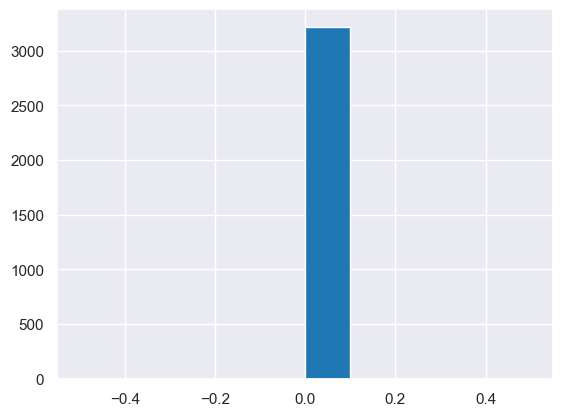

In [65]:
df_price.stack().hist()